# Modeling time series with exponential smoothing methods

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf 
from datetime import date
from statsmodels.tsa.holtwinters import (ExponentialSmoothing, SimpleExpSmoothing, Holt)
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
plt.style.use('fivethirtyeight')
sns.set_palette('cividis')
COLORS = [plt.cm.RdYlGn(x) for x in [0.1, 0.3, 0.5, 0.7]]
COLORS

[(0.8392925797770088, 0.18454440599769317, 0.1528642829680892, 1.0),
 (0.9914648212226067, 0.677354863514033, 0.37808535178777386, 1.0),
 (0.9970780469050365, 0.9987697039600154, 0.7450211457131872, 1.0),
 (0.6460592079969245, 0.8488273740868898, 0.4151480199923107, 1.0)]

In [3]:
# download the adjusted stock prices for google
df = yf.download('GOOG', start='2010-01-01', end='2020-12-31', adjusted=True)

[*********************100%***********************]  1 of 1 completed


In [4]:
# Aggregate to monthly frequency
goog = df.resample('M').last().rename(columns = {'Adj Close': 'adj_close'}).adj_close


In [5]:
# divide into train and test split

train_indices = goog.index.year < 2020
goog_train = goog[train_indices]
goog_test = goog[~train_indices]

test_length = len(goog_test)

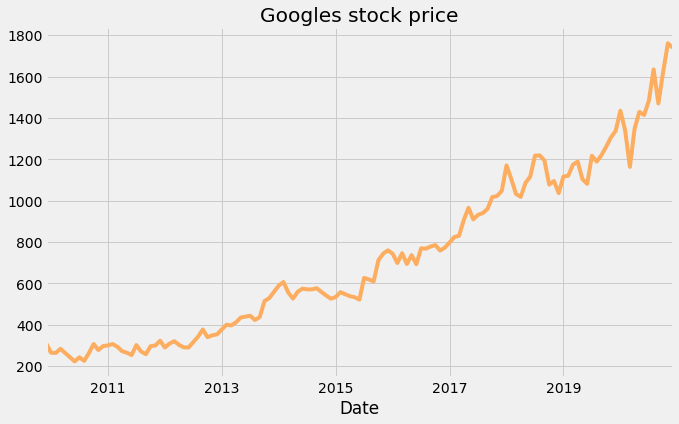

In [6]:
# plot the prices
fig, ax = plt.subplots(figsize = (10, 6))
goog.plot(title = 'Googles stock price', ax = ax, color = COLORS[1])
plt.show()

### Simple exponential smoothing model (SES)

In [16]:
# Fit 3 simple exponential smoothing models (SES) and forecast for them

ses_1 = SimpleExpSmoothing(goog_train).fit(smoothing_level= 0.2)
ses_forecast_1 = ses_1.forecast(test_length)


ses_2 = SimpleExpSmoothing(goog_train).fit(smoothing_level= 0.5)
ses_forecast_2 = ses_2.forecast(test_length)


ses_3 = SimpleExpSmoothing(goog_train).fit()
alpha = ses_3.model.params['smoothing_level']
ses_forecast_3 = ses_3.forecast(test_length)


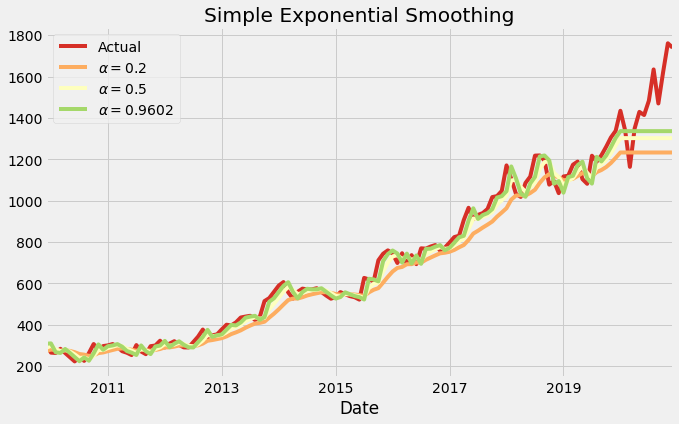

In [8]:
# plot the original prices and the models resutls

ts1 = pd.concat([ses_1.fittedvalues, ses_forecast_1], axis = 0) 
ts2 = pd.concat([ses_2.fittedvalues, ses_forecast_2], axis = 0) 
ts3 = pd.concat([ses_3.fittedvalues, ses_forecast_3], axis = 0) 


fig, ax = plt.subplots(figsize = (10, 6))
goog.plot(color = COLORS[0], title = 'Simple Exponential Smoothing', label = 'Actual', legend = True, ax = ax)

ts1.plot(color = COLORS[1], legend = True, label=r'$\alpha=0.2$')
ts2.plot(color = COLORS[2], legend = True, label=r'$\alpha=0.5$')
ts3.plot(color = COLORS[3], legend = True, label=r'$\alpha={0:.4f}$'.format(alpha))

plt.show()

### Holts smoothing model



In [15]:
# fit 3 variants of holts smoothing model and create forecasts

# Holts with linear trend
hs_1 = Holt(goog_train).fit()
hs_forecast_1 = hs_1.forecast(test_length)

# Holts with exponential trend
hs_2 = Holt(goog_train, exponential= True).fit()
hs_forecast_2 = hs_2.forecast(test_length)

# Holts model with exponential trend and damping
hs_3 = Holt(goog_train, exponential=False, damped_trend = True).fit(damping_trend = 0.99)
hs_forecast_3 = hs_3.forecast(test_length)

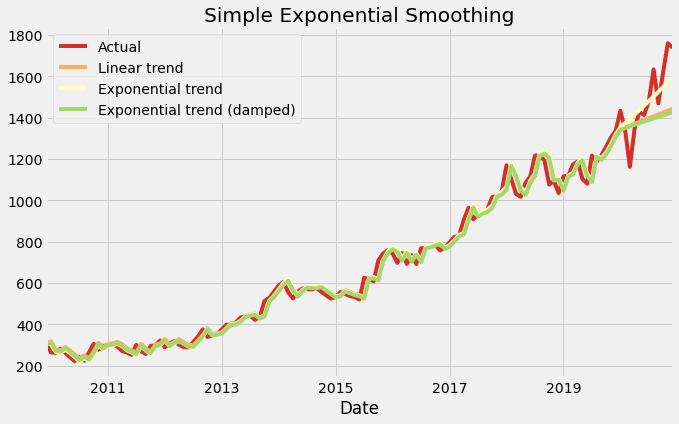

In [10]:
# Plot the original prices and models' results 
ts1 = pd.concat([hs_1.fittedvalues, hs_forecast_1], axis = 0) 
ts2 = pd.concat([hs_2.fittedvalues, hs_forecast_2], axis = 0) 
ts3 = pd.concat([hs_3.fittedvalues, hs_forecast_3], axis = 0) 


fig, ax = plt.subplots(figsize = (10, 6))

goog.plot(color = COLORS[0], title = 'Simple Exponential Smoothing', label = 'Actual', legend = True, ax = ax)

ts1.plot(color = COLORS[1], legend = True, label= r'Linear trend')
ts2.plot(color = COLORS[2], legend = True, label=r'Exponential trend')
ts3.plot(color = COLORS[3], legend = True, label=r'Exponential trend (damped)')

plt.show()

# Holt-Winter's Seasonal Smoothing

In [14]:
SEASONAL_PERIODS = 12

# Holt-Winter's with exponential trend 
hw_1 = ExponentialSmoothing(goog_train, trend = 'mul', seasonal= 'add', seasonal_periods= SEASONAL_PERIODS).fit()
hw_forecast_1 = hw_1.forecast(test_length)

# Holt-Winter's with exponential trend and damping

hw_2 = ExponentialSmoothing(goog_train, trend='mul', seasonal='add', 
                            seasonal_periods=SEASONAL_PERIODS, damped_trend = True).fit()

hw_forecast_2 = hw_2.forecast(test_length)

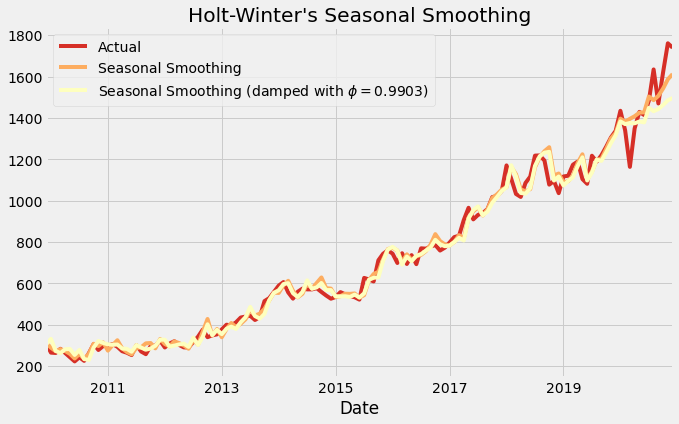

In [12]:
ts1 = pd.concat([hw_1.fittedvalues, hw_forecast_1], axis = 0) 
ts2 = pd.concat([hw_2.fittedvalues, hw_forecast_2], axis = 0) 

fig, ax = plt.subplots(figsize = (10, 6))

goog.plot(color=COLORS[0], title="Holt-Winter's Seasonal Smoothing", label='Actual', legend=True)

ts1.plot(color=COLORS[1], legend=True, label='Seasonal Smoothing')

phi = hw_2.model.params['damping_trend']
plot_label = f'Seasonal Smoothing (damped with $\phi={phi:.4f}$)'

ts2.plot(color=COLORS[2], legend=True, label=plot_label)
plt.show()